In [1]:
# 2023.2.2
# PolyU ws5

# plot the weight distribution before and after permutation

In [ ]:
# init

# for the reproductivity
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from tensorboardX import SummaryWriter
# import pandas as pd

import numpy as np

# import math
import matplotlib.pyplot as plt

# from tqdm import tqdm
from tqdm import trange

# set the random seed
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
        
setup_seed(2022)

print("hello world")

hello world


In [3]:
# parameters
width = 320
k_period = 5
Is_lr_decay = True
gamma = 0.998
k_max = 200
epoches = 6400
weight_decay = 0

In [4]:
# initial the permutation matrix
Matrix_IsPerm = np.zeros([epoches//(k_period-1) + 1, width * 2])
print(np.shape(Matrix_IsPerm))

Matrix_IsPerm[2,:] = np.ones(width*2)

(1601, 640)


x_train: torch.FloatTensor torch.Size([1600, 1])
y_train: torch.FloatTensor torch.Size([1600, 1])
x_test: torch.FloatTensor torch.Size([400, 1])
y_test: torch.FloatTensor torch.Size([400, 1])


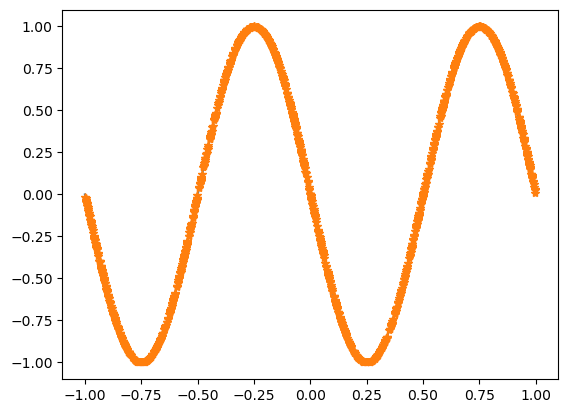

In [ ]:
# product data

num_sample = 2000

num_train = int(num_sample*0.8)
num_test = int(num_sample*0.2)

# x \in [-1, 1]
x_train = torch.rand(num_train,1)*2-1
print('x_train:', x_train.type(), x_train.shape)


# certain function expression: y = sin(2 \pi x)
y_train = - torch.sin(2 * torch.pi * x_train)

print('y_train:', y_train.type(), y_train.shape)
    

# generate uniformly distributed test data
temp = torch.linspace(-1, 1, num_test)
                      
# for consistency of tensor sizes
x_test = torch.unsqueeze(temp,1)
print('x_test:', x_test.type(), x_test.shape)

# certain function expression: y = sin(2 \pi x)
y_test = - torch.sin(2 * torch.pi * x_test)

print('y_test:', y_test.type(), y_test.shape)

plt.plot(x_test, y_test)
plt.plot(x_train, y_train, marker="*", linestyle="None")
plt.show()

In [ ]:
# create data loaders.
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

batch_size = 10

train_dataloader = DataLoader(train, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size = num_test, shuffle=False)


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([400, 1])
Shape of y: torch.Size([400, 1]) torch.float32
Shape of X [N, C, H, W]: torch.Size([10, 1])
Shape of y: torch.Size([10, 1]) torch.float32


In [ ]:
# Define model

actual_width = width * 2

class NN(nn.Module):
    def __init__(self, layers=[1, actual_width, 1, 1]):
        # First initial the __init__ in nn.Module 
        super(NN, self).__init__()

        self.layer1 = nn.Linear(in_features=layers[0], out_features=layers[1])
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(in_features=layers[1], out_features=layers[2], bias=False)
        self.layer3 = nn.Linear(in_features=layers[2], out_features=layers[3], bias=True)


    def forward(self, x):
        unacti = self.layer1(x)
        hidden1 = self.relu(unacti)
        hidden2 = self.layer2(hidden1)
        logits = self.layer3(hidden2)
    
        return logits
    
model = NN().to(device)
print(model)

parm_init = {}
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())
    parm_init[name]=parameters.cpu().detach().numpy()
    
layer1 = parm_init['layer1.weight']
print('layer1.weight:\n',layer1.T)

layer2 = parm_init['layer2.weight']
print('layer2.weight:\n',layer2)

NN(
  (layer1): Linear(in_features=1, out_features=640, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=640, out_features=1, bias=False)
  (layer3): Linear(in_features=1, out_features=1, bias=True)
)
layer1.weight : torch.Size([640, 1])
layer1.bias : torch.Size([640])
layer2.weight : torch.Size([1, 640])
layer3.weight : torch.Size([1, 1])
layer3.bias : torch.Size([1])
layer1.weight:
 [[-5.42068481e-01 -5.83771229e-01  6.99825287e-01 -6.14846110e-01
   1.08508825e-01 -4.61830497e-01 -1.38699770e-01  5.60822010e-01
   4.74456787e-01 -9.93781924e-01  6.65856838e-01  3.96402717e-01
  -8.45173597e-01  3.61393452e-01 -8.58909249e-01  5.12638569e-01
   4.09862995e-01 -7.02820420e-01 -1.90099001e-01  1.68211937e-01
  -8.46280098e-01  3.48572969e-01  1.15309954e-01 -9.56689477e-01
   4.89656687e-01 -1.04434848e-01  6.54059172e-01  3.85952592e-01
  -8.86522293e-01 -2.38339663e-01 -1.65128469e-01 -1.71792507e-02
  -9.47421789e-02  7.95842648e-01 -8.21847439e-01 -3.98650765e-01
   6.143

In [ ]:
'''
set the first layers weight as a series of ReLU
    and the second layer to be uniformed distributed
'''

# weight_scale = 4 * width + 2
weight_scale = 1

scale = 1

print(weight_scale)

def weights_init(shape, dtype=None):
    # initial the weights in the first layer as [1, 1, ..., 1, -1, -1, ..., -1]

    # get the half of the shape
    shape_np = np.array(shape)
    shape_half = np.divide(shape_np,2)
    shape_half = np.ceil(shape_half).tolist()
    
    W = torch.cat((torch.ones(int(shape_half[0])), -1*torch.ones(int(shape_half[0]))))

    return torch.reshape(W, shape)


def bias_init(shape, dtype=None):
    shape_half = int(np.divide(shape, 2))
    return torch.cat((torch.linspace(-1, 1, shape_half), torch.linspace(-1, 1, shape_half)))


def coefficient_init(shape, dtype=None):
    
    t = torch.linspace(-1 / weight_scale, 1 / weight_scale, shape[1])
    
    # initialize the weight as sorted.
    return torch.reshape(t, shape)

# initialize the weights and bias
with torch.no_grad():
    for name, param in model.named_parameters():
        if 'layer1.weight' in name:
            param.copy_(weights_init([actual_width, 1]))
            param.requires_grad = False  # freeze the weights of first layer
            
        if 'layer1.bias' in name:
            param.copy_(bias_init(actual_width))
            param.requires_grad = False  # freeze the weights of first layer
            
        if 'layer2.weight' in name:
            param.copy_(coefficient_init([1, actual_width]))
            
        if 'layer3.weight' in name:
            param.copy_(torch.tensor(scale))
            
parm = {}
for name,param in model.named_parameters():
    print(name,':',param.size())
    parm[name]=param.cpu().detach().numpy()

weight1 = parm['layer1.weight']
print('layer1.weight:\n', weight1.T)

bias1 = parm['layer1.bias']
print('layer1.bias:\n', bias1)

weight2 = parm['layer2.weight']
print('layer2.weight:\n',weight2)

weight3 = parm['layer3.weight']
print('layer3.weight:\n',weight3)

weight_0 = weight2

# get the ranking idx
rank_old = np.argsort(np.argsort(weight_0))

# print(rank)

1
layer1.weight : torch.Size([640, 1])
layer1.bias : torch.Size([640])
layer2.weight : torch.Size([1, 640])
layer3.weight : torch.Size([1, 1])
layer3.bias : torch.Size([1])
layer1.weight:
 [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  

In [10]:
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

In [11]:
writer = SummaryWriter(comment="plot-BeforeAfter")

disp_interval = 100

In [ ]:
# k_period = 10

# try to adjust the premutation period by the decay of learning rate
def train_by_permu_adjust(dataloader, model, loss_fn, optimizer, epoch, epoch_0, k_num, rank_old):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Move the data to the computational device
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # laerning rate decay exponienally
    if Is_lr_decay == True:
        scheduler.step()
    
    k_adjust = k_period
    
    if k_adjust > k_max:
        k_adjust = k_max
        
    writer.add_scalar('Train/k', k_adjust, epoch)
    writer.add_scalar('Train/distance', epoch + 1 - epoch_0, epoch)
    
    # Permutation
    with torch.no_grad():
        
        if (epoch + 1 - epoch_0) == k_adjust:
            
            epoch_0 = epoch
            
            for name,param in model.named_parameters():
                if 'layer2.weight' in name:
                    
                    # get the trained weight
                    weight_t = param.cpu().detach().numpy()

                    # get the ranking idx
                    rank = np.argsort(np.argsort(weight_t))

                    # take the untrained weight with the ranking idx
                    weight_permu = np.take(weight_0, rank)

                    # assign the value back
                    param.copy_(torch.from_numpy(weight_permu))
                    
                    
                    
                    # to see whether it's permuted
                    IsPermu = (rank == rank_old)
                    
                    Matrix_IsPerm[k_num,:] = (IsPermu > 0.5).astype(int)
                    
                    
            k_num += 1
            rank_old = rank
                    
    return epoch_0, k_num, rank_old


In [ ]:
def test(dataloader, model, loss_fn, epoch, epoch_0, k_num):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
    
            test_loss += loss_fn(pred, y).item()

            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    # loss with regularization
    if weight_decay > 0:
        loss = test_loss + reg_loss(model)
        total_loss = loss.item()
    else:
        total_loss = test_loss

    # write
    # write to show loss/acc/lr on tensorboard
    writer.add_scalar('Train/Loss',total_loss,epoch)
    writer.add_scalar('Train/Approximation',test_loss,epoch)
    writer.add_scalar('Train/Learning Rate',optimizer.state_dict()['param_groups'][0]['lr'],epoch)
    
    if epoch == epoch_0:
        writer.add_scalar('Test/Permutation', total_loss, k_num)
    
    if epoch % disp_interval == 0:
        for name, layer in model.named_parameters():
            if 'layer2.weight' in name:
                writer.add_histogram(name + '_grad_weight_decay', layer.grad, epoch)
                writer.add_histogram(name + '_data_weight_decay', layer, epoch)



In [ ]:
def test2(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size



In [ ]:
def output_final(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    
    # loss with regularization
    if weight_decay > 0:
        loss = test_loss + reg_loss(model)
        total_loss = loss.item()
    else:
        total_loss = test_loss
        
    
    print(f"Test error: \n Avg loss: {total_loss:e}")

In [ ]:


epoch_0 = 0
k_num = 0

for epoch in trange(epoches):

    [epoch_0, k_num, rank_old] = train_by_permu_adjust(train_dataloader, model, loss_fn, optimizer, epoch, epoch_0, k_num, rank_old)

    torch.use_deterministic_algorithms(True)
    test(test_dataloader, model, loss_fn, epoch, epoch_0, k_num)

print("Hallelujah!")

100%|██████████| 6400/6400 [46:12<00:00,  2.31it/s]

Hallelujah!


In [18]:
output_final(test_dataloader, model, loss_fn)

Test error: 
 Avg loss: 5.103216e-05


In [ ]:
parm_final = {}
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())
    print(type(parameters))
    parm_final[name]=parameters.cpu().detach().numpy()

weight1 = parm_final['layer1.weight']
print('layer1.weight:\n', weight1.T)

bias1 = parm_final['layer1.bias']
print('layer1.bias:\n', bias1)

weight2 = parm_final['layer2.weight']
print('layer2.weight:\n',weight2)

weight3 = parm_final['layer3.weight']
print('layer3.weight:\n',weight3)

layer1.weight : torch.Size([640, 1])
<class 'torch.nn.parameter.Parameter'>
layer1.bias : torch.Size([640])
<class 'torch.nn.parameter.Parameter'>
layer2.weight : torch.Size([1, 640])
<class 'torch.nn.parameter.Parameter'>
layer3.weight : torch.Size([1, 1])
<class 'torch.nn.parameter.Parameter'>
layer3.bias : torch.Size([1])
<class 'torch.nn.parameter.Parameter'>
layer1.weight:
 [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1. 

torch.FloatTensor torch.Size([400, 1])


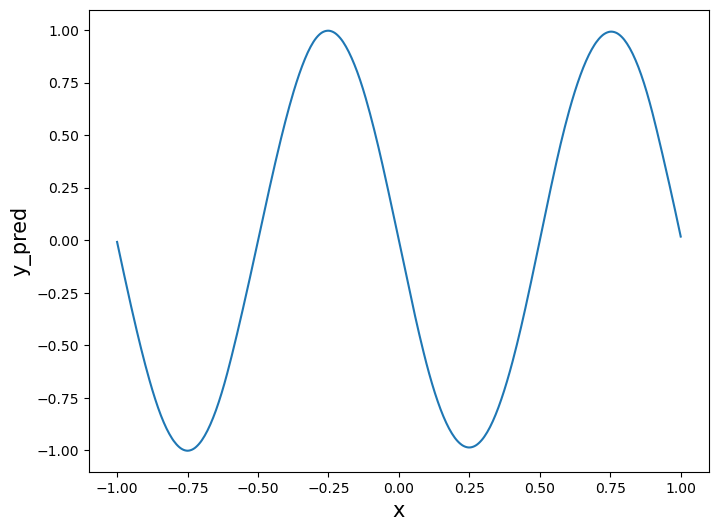

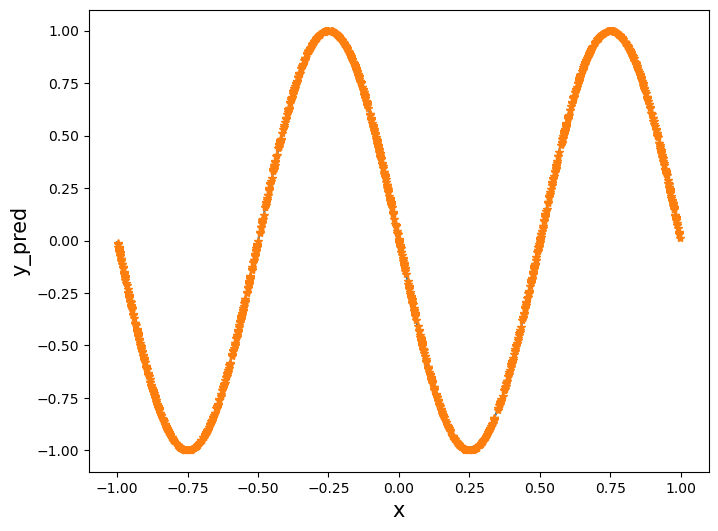

In [ ]:
with torch.no_grad():
    
    X_test = x_test.to(device)
    Y_pred = model(X_test)

    y_pred = Y_pred.cpu()
    
print(y_pred.type(), y_pred.shape)

plt.figure(figsize=(8, 6))
plt.plot(x_test, y_pred)
plt.xlabel('x', size=15)
plt.ylabel('y_pred', size=15)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x_test, y_pred)
plt.plot(x_train, y_train, marker="*", linestyle="None")
plt.xlabel('x', size=15)
plt.ylabel('y_pred', size=15)
plt.show()

(1601, 640)


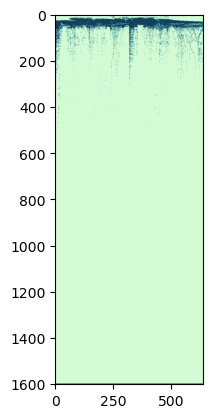

In [21]:
from palettable.cartocolors.sequential import DarkMint_4

print(np.shape(Matrix_IsPerm))

plt.imshow(np.ones(np.shape(Matrix_IsPerm)) - Matrix_IsPerm, cmap=DarkMint_4.mpl_colormap)
plt.savefig('plot'+str(width)+'.pdf', bbox_inches='tight')

[  0.   159.75 319.5  479.25 639.  ]


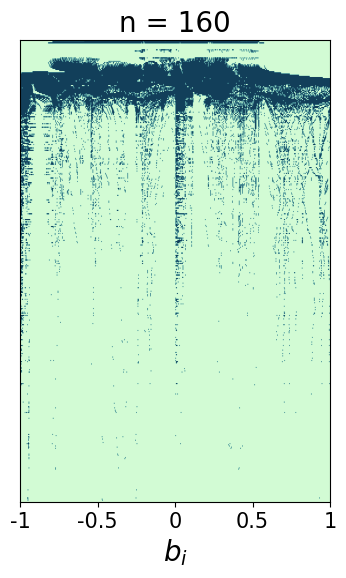

In [27]:
plt.figure(figsize=(4, 6))
plt.title('n = 160', fontsize=20)
plt.xlabel('$b_i$', fontsize=20)
plt.yticks([])
labels_pos = np.linspace(0, np.shape(Matrix_IsPerm)[1]-1, 5)
print(labels_pos)
plt.xticks(labels_pos, ['-1', '-0.5', '0', '0.5', '1'], fontsize=15)
# plt.xticks(fontsize=15)
Matrix_IsPerm_inverse = (np.ones(np.shape(Matrix_IsPerm)) - Matrix_IsPerm)[0:400,:]
plt.imshow(Matrix_IsPerm_inverse, cmap=DarkMint_4.mpl_colormap, aspect='auto')

np.savetxt('plot'+str(width)+'.txt', Matrix_IsPerm_inverse)

plt.savefig('plot'+str(width)+'short.pdf', bbox_inches='tight')

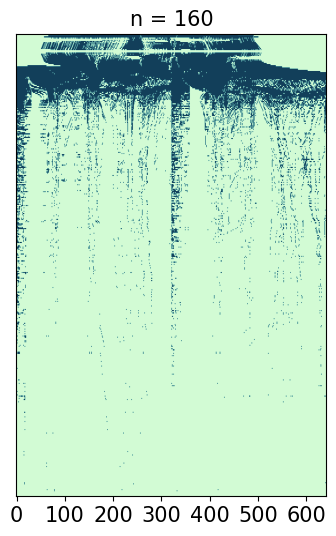

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from palettable.cartocolors.sequential import DarkMint_4

A = np.loadtxt('plot160.txt')

plt.figure(figsize=(4, 6))
plt.title('n = 160', fontsize=15)
plt.yticks([])
plt.xticks(fontsize=15)
plt.imshow(A[0:400,:], cmap=DarkMint_4.mpl_colormap, aspect='auto')